# Исследование данных пользователей развлекательного приложения Procrastinate Pro+ и анализ окупаемости рекламы

Для анализа были переданы данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года: лог сервера с данными об их посещениях, выгрузка их покупок за этот период и рекламные расходы.

Основная задача: Разобраться в причине убытков и помочь компании выйти в плюс.

Работа состоит из 7 пунктов:
 1. Загрузка данных и их подготовка к анализу
 2. Задача функций для расчёта и анализа LTV, ROI, удержания и конверсии
 3. Исследовательский анализ данных
 4. Маркетинг
 5. Оценка окупаемости рекламы
 6. Выводы

## Шаг. Загрузка данных и их подготовка к анализу

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

### Подготовка таблицы visits

In [3]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Заметим, что названия столбцов указаны некорректно, а также тип данных в столбцах "Session Start" и "Session End" задан как object, что потребуется изменить на datetime.

In [5]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [7]:
visits.channel.value_counts().to_frame().rename(columns = {'channel':'channel count'})

channel count
organic                    107760
TipTop                      54794
FaceBoom                    49022
WahooNetBanner              20465
LeapBob                     17013
OppleCreativeMedia          16794
RocketSuperAds              12724
YRabbit                      9053
MediaTornado                 8878
AdNonSense                   6891
lambdaMediaAds               6507

In [8]:
visits.device.value_counts().to_frame().rename(columns = {'device':'device count'})

device count
iPhone         112603
Android         72590
PC              62686
Mac             62022

In [9]:
visits.region.value_counts().to_frame().rename(columns = {'region':'region count'})

region count
United States        207327
UK                    36419
France                35396
Germany               30759

Ошибок в названиях или лишних объектов в столбцах "channel", "device" и "region" не обнаружено.

In [10]:
visits.duplicated().sum()

0

Полных дубликатов нет.

In [11]:
visits.duplicated(subset=['session_start', 'session_end']).sum()

0

Строк, с совпадающим временем начала и конца сессии также не выявлено.

In [12]:
print('Дата первого входа в приложение:', visits.session_start.min().date())
print('Дата последнего выхода из приложения:', visits.session_end.max().date())

Дата первого входа в приложение: 2019-05-01
Дата последнего выхода из приложения: 2019-11-01


In [13]:
visits.head()

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

In [14]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


### Подготовка таблицы orders

In [15]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Как и в прошлой таблице, проблема с названиями столбцов и с типом данных в столбце "Event Dt".

In [17]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [18]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [19]:
orders.revenue.describe().round(2).to_frame()

revenue
count  40212.00
mean       5.37
std        3.45
min        4.99
25%        4.99
50%        4.99
75%        4.99
max       49.99

In [20]:
orders.revenue.value_counts().to_frame().rename(columns = {'revenue':'revenue count'})

revenue count
4.99           38631
5.99             780
9.99             385
49.99            212
19.99            204

In [21]:
orders.duplicated().sum()

0

Полных дубликатов нет.

In [22]:
print('Дата первого заказа:', orders.event_dt.min().date())
print('Дата последнего заказа:', orders.event_dt.max().date())

Дата первого заказа: 2019-05-01
Дата последнего заказа: 2019-10-31


In [23]:
orders.head()

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


### Подготовка таблицы costs

In [25]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [26]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Как и в прошлой таблице, проблема с названиями столбцов и с типом данных в столбце "dt".

In [27]:
costs.columns = ['dt', 'channel', 'costs']

In [28]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

В конечных данных тип столбца "dt" будет отображаться как "object", однако в реальности, данные в этом столбце изменились на дату без времени.

In [29]:
costs.duplicated().sum()

0

Полных дубликатов нет.

In [30]:
costs.channel.value_counts().to_frame().rename(columns = {'channel':'channel count'})

channel count
TipTop                        180
RocketSuperAds                180
MediaTornado                  180
YRabbit                       180
OppleCreativeMedia            180
lambdaMediaAds                180
WahooNetBanner                180
AdNonSense                    180
LeapBob                       180
FaceBoom                      180

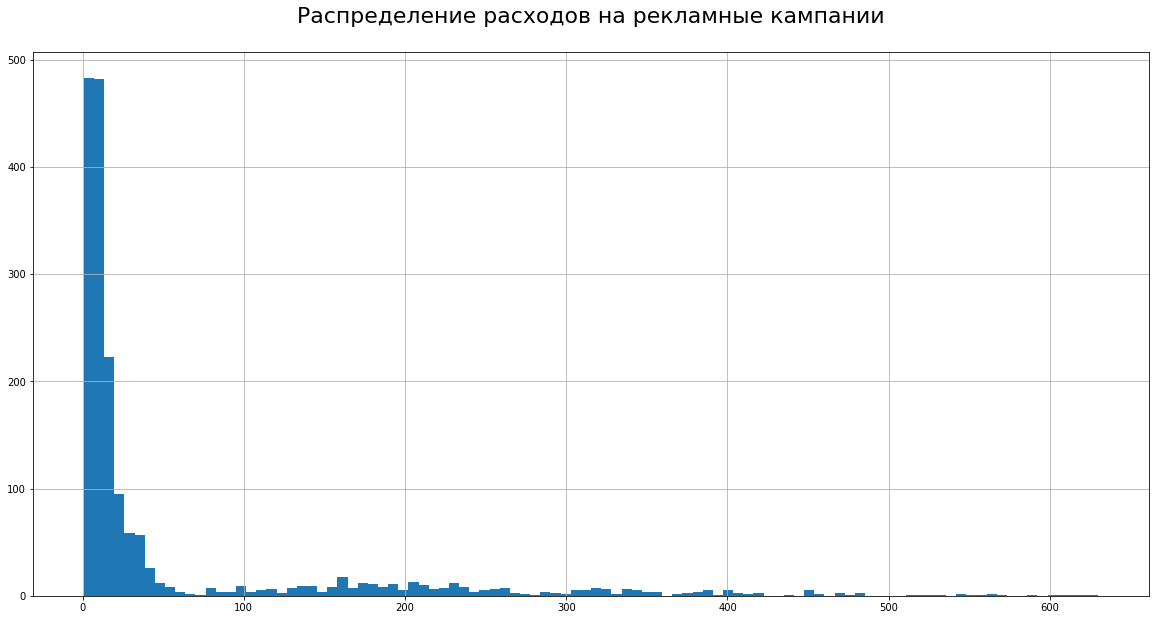

In [31]:
costs.costs.hist(figsize=(20, 10), bins=100)
plt.title('Распределение расходов на рекламные кампании' + "\n", fontsize=22);

In [32]:
costs.costs.describe().round(1).to_frame().T

count  mean    std  min  25%   50%   75%    max
costs  1800.0  58.6  107.7  0.8  6.5  12.3  33.6  630.0

In [33]:
print('Дата запуска рекламных кампаний:', costs.dt.min())
print('Дата окончания рекламных кампаний:', costs.dt.max())

Дата запуска рекламных кампаний: 2019-05-01
Дата окончания рекламных кампаний: 2019-10-27


In [34]:
costs.pivot_table(index='dt', values='costs', aggfunc='count')

costs
dt               
2019-05-01     10
2019-05-02     10
2019-05-03     10
2019-05-04     10
2019-05-05     10
...           ...
2019-10-23     10
2019-10-24     10
2019-10-25     10
2019-10-26     10
2019-10-27     10

[180 rows x 1 columns]

In [35]:
(costs.pivot_table(index='dt', values='costs', aggfunc='count')['costs'] != 10).sum()

0

Каждый день, с 01.05.2019 по 10.27.2019, выходило ровно по 10 реклам.

In [36]:
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [37]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Итог по подготовке данных

Для анализа было предоставлено 3 датасета visits, orders и costs. 

* visits имеет размерность 309901 на 6. Названия столбцов были написаны некорректно и были переделаны. Полных дубликатов найдено не было, частичных дубликатов тоже. Пропущенных значений не выявлено. Тип данных в столбцах с началом и концом сессий был изменен на datetime. Выбивающихся или ошибочных значений в столбцах region, device, channel не обнаружено. Данные предоставлены с 01.05.2019 по 01.11.2019.
* orders: 40212 на 3. Названия столбцов были написаны некорректно и были переделаны. Полных дубликатов найдено не было, частичных дубликатов тоже. Пропущенных значений не выявлено. Тип данных в столбце с датой и временем покупки был изменен на datetime. 96% всех заказов обошлись в 4.99 у.е. Данные предоставлены с 01.05.2019 по 31.10.2019.
* costs: 1800 на 3. Названия столбцов были написаны некорректно и были переделаны. Полных дубликатов найдено не было, частичных дубликатов тоже. Пропущенных значений не выявлено. Тип данных в столбце с датой рекламы был изменен на дату. Реклама вышла на каждой площадке ровно по 180 раз. В среднем одна реклама обошлась в 59 у.е., с минимальной стоимостью = 0.8 у.е. и максимальной = 630. Каждый день, с 01.05.2019 по 10.27.2019, выходило ровно по 10 реклам.

## Шаг. Задача функции для расчёта и анализа LTV, ROI, удержания и конверсии

In [38]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [39]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [40]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [41]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [42]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [43]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [44]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [45]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Шаг. Исследовательский анализ данных

In [46]:
profiles = get_profiles(visits, orders, costs)

In [47]:
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.205714  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

In [48]:
print('Минимальная дата привлечения пользователей:', profiles.dt.min())
print('Максимальная дата привлечения пользователей:', profiles.dt.max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


За промежуток времени с 01.05.2019 по 27.10.2019 приложением воспользовалось 150008 различных пользователей. Даты соответствуют заявленным в ТЗ.

In [49]:
(
    profiles
    .groupby('region')
    .agg({'user_id':'count', 'payer':'mean'})
    .sort_values(by='user_id', ascending=False)
    .style.format({'payer':'{:.2%}'})
)

Приложением пользуются клиенты и 4-х стран: США, Великобритания, Франция и Германия. Абсолютное большинство пользователей приходит из США (67% от общего количества привлеченных пользователей). Клиенты из США, также, имеют самый высокий показатель платежеспособности - 6.9%.

In [50]:
(
    profiles
    .groupby('device')
    .agg({'user_id':'count', 'payer':'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer':'{:.2%}'})
)

Пользователи заходят в Procrastinate Pro+ с 4-х различных устройств: Мак, Айфон, Андройд и ПК. Среди этих девайсов, больше всего платящих пользователей используют Мак - 6.36%, однако этих пользователей меньше всего. Второе устройство по содержанию наибольшего количества платящих клиентов - Айфон, у него 6.21% платящих, а также самый высокий результат по количеству клиентов - 54479 человек, что в 1.8 раз больше, чем количество пользователей Маком.

In [51]:
(
    profiles
    .groupby('channel')
    .agg({'user_id':'count', 'payer':'mean'})
    .assign(paying_user_count = lambda x: x['payer'] * x['user_id'])
    .sort_values(by='paying_user_count', ascending=False)
    .style.format({'payer':'{:.2%}', 'paying_user_count':'{:.0f}'})
)

Больше всего платящих пользователей пришло из канала FaceBoom: 3557 человек или 12.2% от общего количества клиентов из FaceBoom. Вторым каналом по количеству платящих идет TipTop: с него пришел 19561 пользователь, из которых 1878 человек являются платящими (9.6%). Больше всего людей попало в приложение самостоятельно, об этом говорит индекс таблицы с названием organic: 56439 пользователей, однако лишь 2.06% от них совершили покупку. Этот процент яввляется наименьшим среди всех каналов, что вполне ожидаемо, поскольку на привлечение этих пользователей ничего не было потрачено.

## Шаг. Маркетинг

In [52]:
costs.costs.sum().round(1)

105497.3

105497 у.е. было потрачено суммарно на рекламу.

In [53]:
costs.groupby('channel').sum().sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

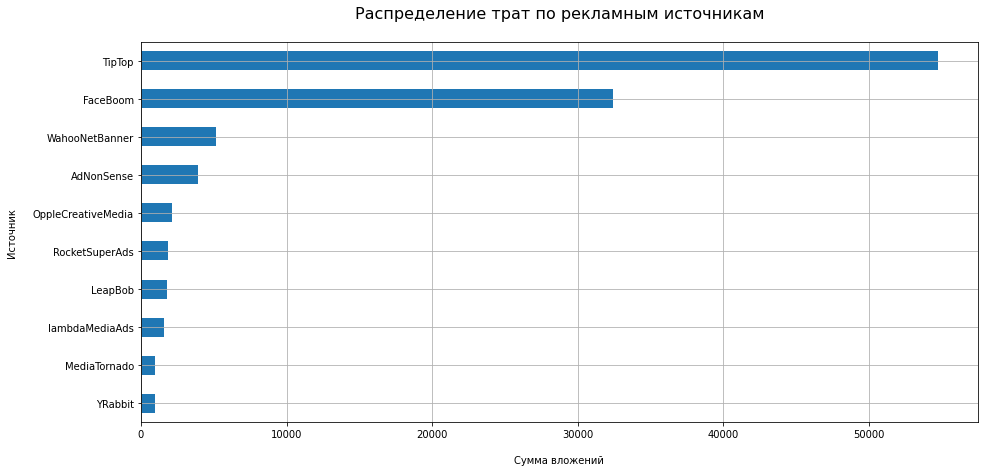

In [54]:
(
    costs.groupby('channel')
    .sum()
    .sort_values(by='costs')
    .rename_axis(None, axis=0)
    .plot(kind='barh', legend=False, figsize=(15, 7), grid=True)
)
plt.title('Распределение трат по рекламным источникам' + "\n", fontsize=16)
plt.xlabel("\n" + 'Сумма вложений', fontsize=10)
plt.ylabel('Источник' + "\n", fontsize=10);

По графику видно, что основная сумма рекламных средств была вложена в два источника: TipTop и FaceBoom. Они занимают практически 83% от всех вложений. Главным лидером, однако, является именно TipTop, занимая более половины всего рекламного бюджета.

In [55]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = costs['dt'].astype('datetime64[W]')
costs

dt         channel  costs      month       week
0     2019-05-01        FaceBoom  113.3 2019-05-01 2019-04-25
1     2019-05-02        FaceBoom   78.1 2019-05-01 2019-05-02
2     2019-05-03        FaceBoom   85.8 2019-05-01 2019-05-02
3     2019-05-04        FaceBoom  136.4 2019-05-01 2019-05-02
4     2019-05-05        FaceBoom  122.1 2019-05-01 2019-05-02
...          ...             ...    ...        ...        ...
1795  2019-10-23  lambdaMediaAds    4.0 2019-10-01 2019-10-17
1796  2019-10-24  lambdaMediaAds    6.4 2019-10-01 2019-10-24
1797  2019-10-25  lambdaMediaAds    8.8 2019-10-01 2019-10-24
1798  2019-10-26  lambdaMediaAds    8.8 2019-10-01 2019-10-24
1799  2019-10-27  lambdaMediaAds   12.0 2019-10-01 2019-10-24

[1800 rows x 5 columns]

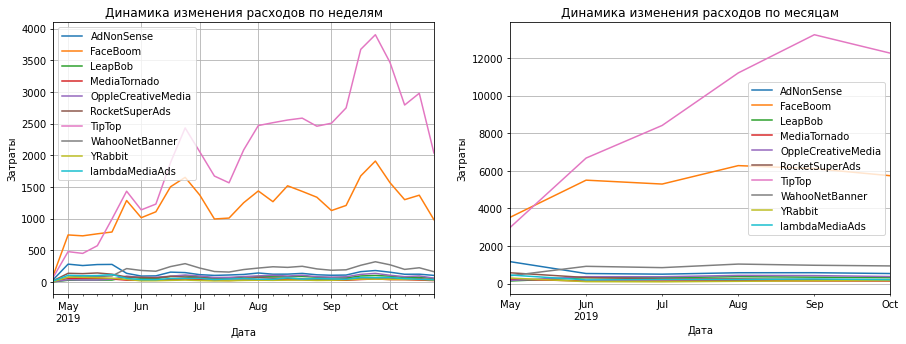

In [56]:
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(figsize=(15, 5), ax=ax1, grid=True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.title('Динамика изменения расходов по неделям')

ax2 = plt.subplot(1, 2, 2)
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(figsize=(15, 5), ax=ax2, grid=True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.title('Динамика изменения расходов по месяцам');

По динамике изменения расходов на рекламу видно, что в TipTop и FaceBoom рекламу закупали стабильно на бОльшие суммы, в отличие от всех остальных источников. В последние недели, однако, расходы на рекламу в TipTop заметно снизились, но, рассматривая закупы рекламы суммарно за месяц, показатель снизился на довольно небольшую сумму.

In [57]:
(
    profiles[['channel', 'user_id', 'acquisition_cost']]
    .groupby('channel')
    .agg({'acquisition_cost':'sum', 'user_id':'count'})
    .assign(share = lambda x: x['acquisition_cost'] / x['user_id'])
    .sort_values(by='share', ascending=False)
    .round(2)
    .rename(columns={'user_id':'Количество привлеченных пользователей',
                     'acquisition_cost':'Затраты на рекламу', 
                     'share':'Средняя стоимость одного клиента'})
)

Затраты на рекламу  Количество привлеченных пользователей  \
channel                                                                         
TipTop                        54751.30                                  19561   
FaceBoom                      32445.60                                  29144   
AdNonSense                     3911.25                                   3880   
lambdaMediaAds                 1557.60                                   2149   
WahooNetBanner                 5151.00                                   8553   
RocketSuperAds                 1833.00                                   4448   
OppleCreativeMedia             2151.25                                   8605   
YRabbit                         944.22                                   4312   
MediaTornado                    954.48                                   4364   
LeapBob                        1797.60                                   8553   
organic                           0.00                                  56439   

                    Средняя стоимость одного клиента  
channel                                               
TipTop                                          2.80  
FaceBoom                                        1.11  
AdNonSense                                      1.01  
lambdaMediaAds                                  0.72  
WahooNetBanner                                  0.60  
RocketSuperAds                                  0.41  
OppleCreativeMedia                              0.25  
YRabbit                                         0.22  
MediaTornado                                    0.22  
LeapBob                                         0.21  
organic                                         0.00

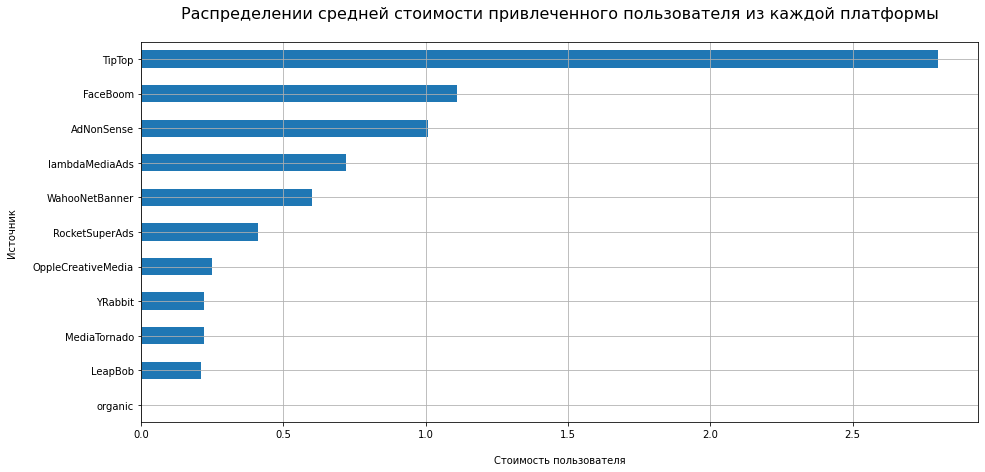

In [58]:
(
    profiles[['channel', 'user_id', 'acquisition_cost']]
    .groupby('channel')
    .agg({'acquisition_cost':'sum', 'user_id':'count'})
    .assign(share = lambda x: x['acquisition_cost'] / x['user_id'])
    .sort_values(by='share')
    .round(2)
    .rename(columns={'user_id':'Количество привлеченных пользователей',
                     'acquisition_cost':'Затраты на рекламу', 
                     'share':'Средняя стоимость одного клиента'})
)['Средняя стоимость одного клиента'].plot(kind='barh', legend=False, figsize=(15, 7), grid=True)

plt.title('Распределении средней стоимости привлеченного пользователя из каждой платформы' + "\n", fontsize=16)
plt.xlabel("\n" + 'Стоимость пользователя', fontsize=10)
plt.ylabel('Источник' + "\n", fontsize=10);

За весь промежуток рекламных кампаний, пользователь из TipTop оказался самым дорогим, причем с огромным отрывом от остальных площадок: он в 2.5 раза дороже, чем клиент из второй по стоимости привлеченного пользователя компании - FaceBoom и более, чем в 13 раз дороже клиента из LeapBob - площадки с самым дешевым пользователем. 

Интересно заметить, что даже при наибольших вложениях в рекламу на TipTop, количество пришедшей аудитории оттуда все равно меньше, чем количество аудитории из FaceBoom: 19561 к 29144. 

На данный момент уже можно сделать вывод, что пользователи, привлеченные из TipTop, должны приносить крайне хороший доход, чтобы окупаться. Если они будут приносить средний доход, сравнимый с FaceBoom или любой другой рекламной платформой, то вложения в рекламу на этой площадке не оправданы. Однако, чтобы сделать окончательный вывод, необходимо посмотреть на коэффициенты окупаемости этой площадки.

## Шаг. Оценка окупаемости рекламы

Поскольку рассматривается окупаемость именно рекламы, включение в анализ органических пользователей лишь нарушит результаты измерений. Органический пользователь привлечен без каких-либо вложений, занимает большую часть всех пользователей приложения и приносит доход, его участие в анализе завысит показатели окупаемости.

In [59]:
ad_profiles = profiles.loc[profiles['channel'] != 'organic']  # профили без "органиков"

observation_date = datetime(2019, 10, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Общие показатели

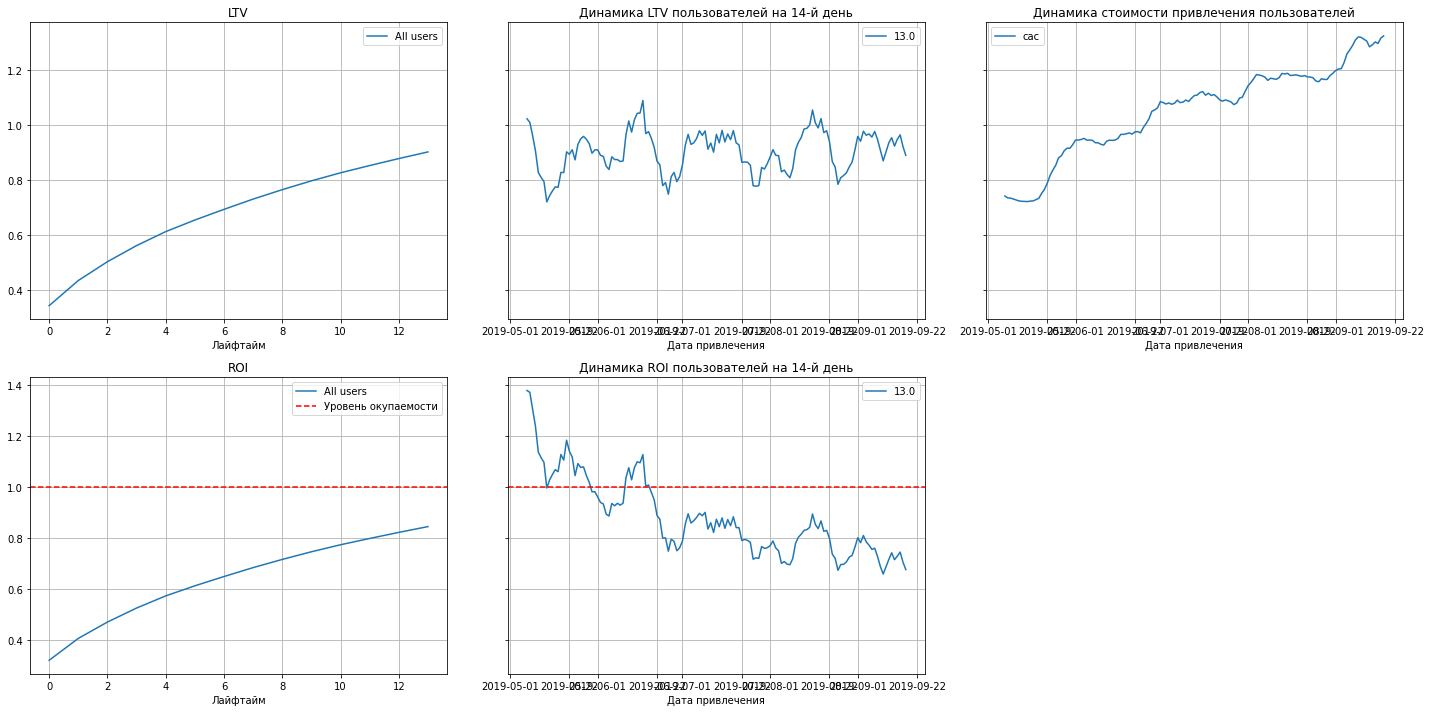

In [60]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ad_profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [61]:
conversion_raw, conversion, conversion_history = get_conversion(ad_profiles, orders, observation_date, horizon_days)
retention_raw, retention, retention_history = get_retention(ad_profiles, visits, observation_date, horizon_days)

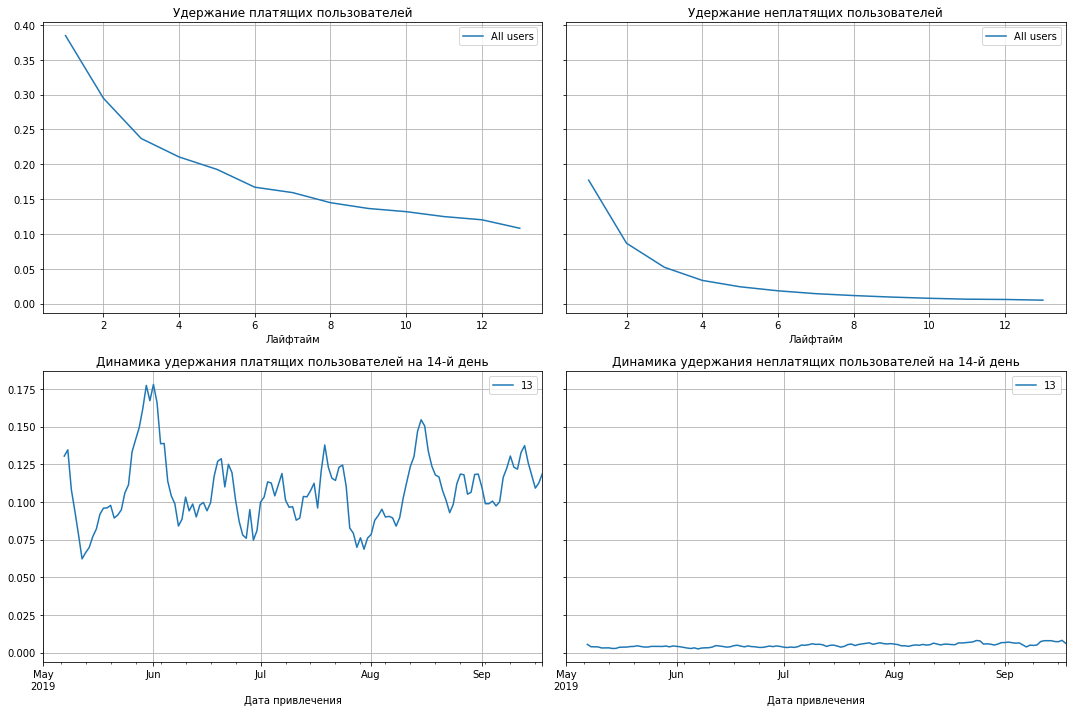

In [62]:
plot_retention(retention, retention_history, horizon_days)

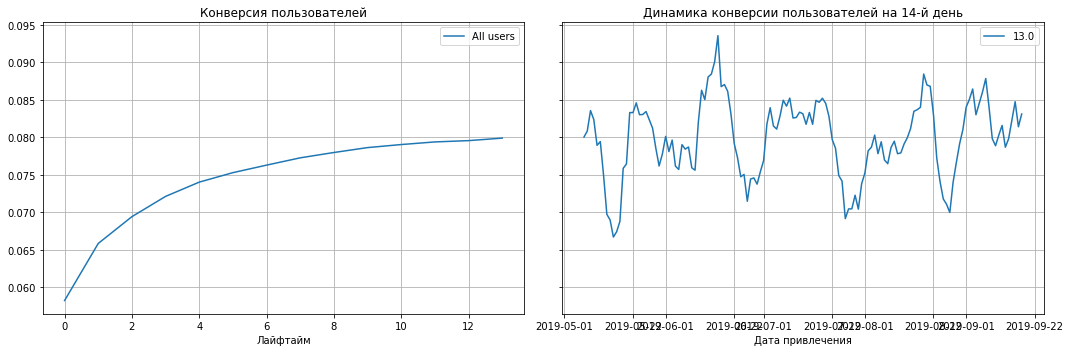

In [63]:
plot_conversion(conversion, conversion_history, horizon_days)

### Окупается ли реклама, направленная на привлечение пользователей в целом?

Нет. Коэффициент ROI немного превышает 0.8, однако не достигает единицы. По динамике его изменения видим, что проблема все больше усиливалась. Начиная со второй половины июня, коэффициент упал ниже прямой окупаемости и больше ее не пересекал. 

Динамика LTV выдает стабильные показатели на протяжении всего участка времени, однако при постоянно увеличивающейся стоимости пользователя, этих показателей недостаточно. С ростом CAC должен расти и коэффициент LTV, для обеспечения стабильного показателя ROI, однако, как мы уже заметили, LTV со временем не увеличился.

### Показатели в разбивке по устройствам

In [64]:
dimensions = ['device']

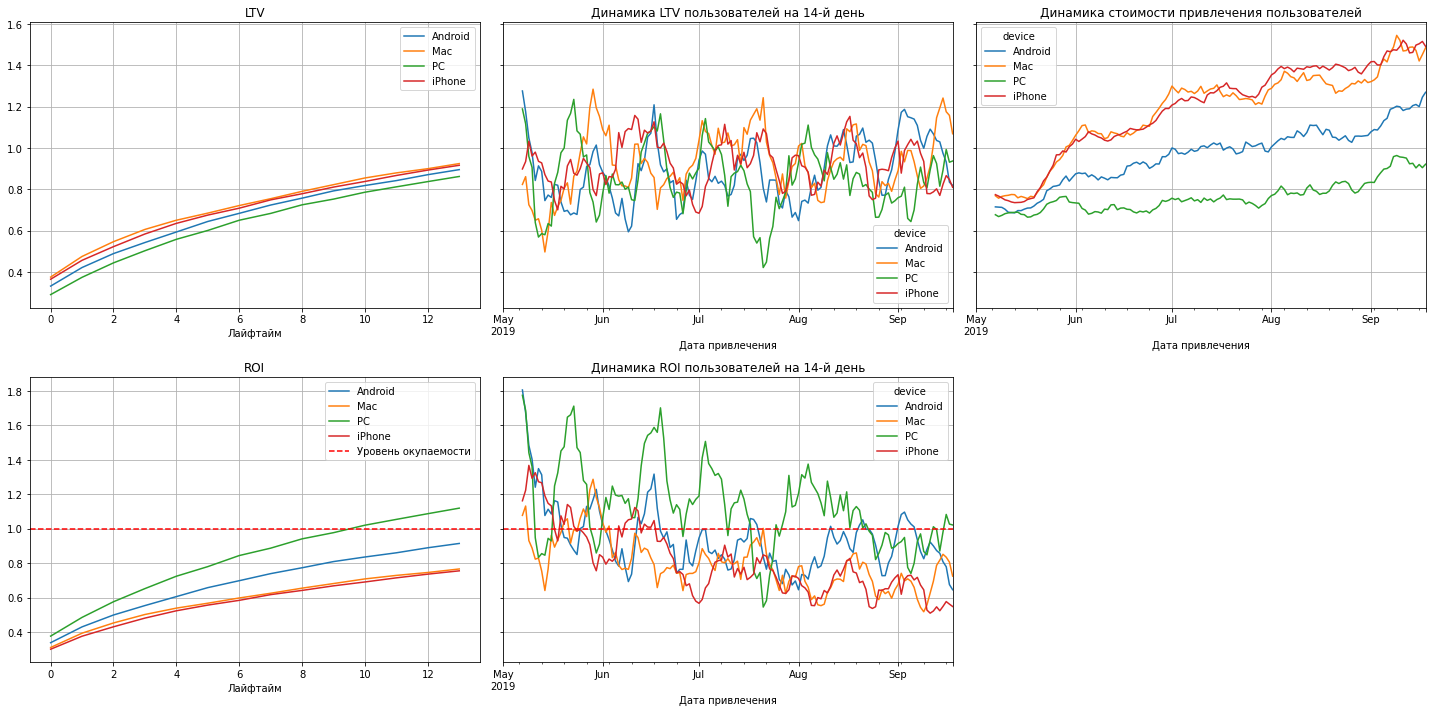

In [65]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [66]:
conversion_raw, conversion, conversion_history = get_conversion(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)
retention_raw, retention, retention_history = get_retention(ad_profiles, visits, observation_date, horizon_days, dimensions=dimensions)

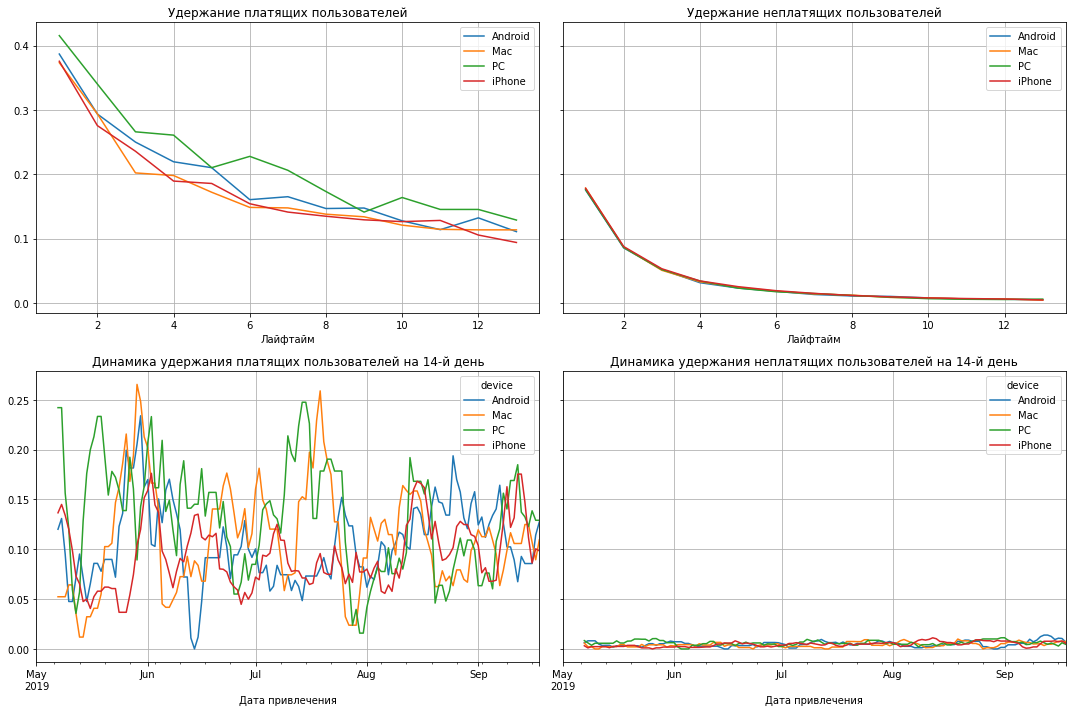

In [67]:
plot_retention(retention, retention_history, horizon_days)

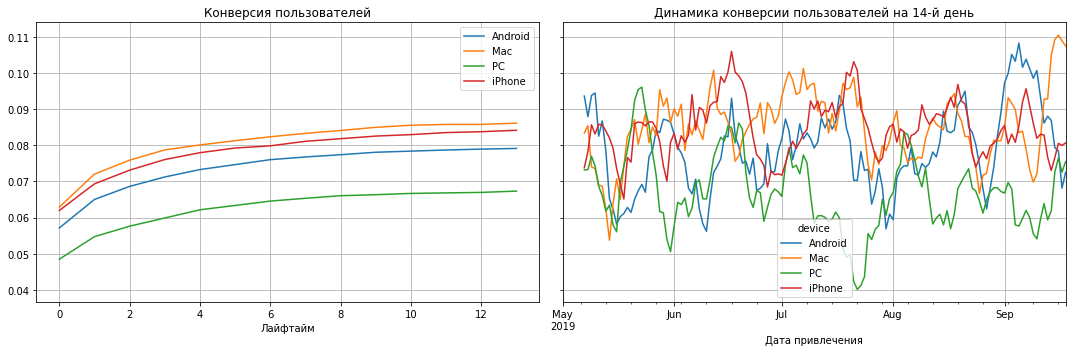

In [68]:
plot_conversion(conversion, conversion_history, horizon_days)

Среди устройств, окупается лишь PC, его показатель ROI превышает 1.1, все остальные устройства показывают отрицательную итоговую окупаемость, где IPhone и Mac имеют ROI < 0.8 - самый низкий показатель. Общий LTV у всех 4-х устройств примерно одинаковый, проблема, опять же, в стоимости привлеченного клиента. По динамике CAC видим, что в начале закупов рекламы, на всех устройствах стоимость нового пользователя была +- одинаковая, однако под конец, пользователи IPhone и Mac сильно выросли в цене (более, чем в два раза). По удержанию, девайсы не сильно отличаются друг от друга, но по конверсии видим, что при том, что пользователи PC - единственные, кто окупаются, переходят из постетителей в клиентов они хуже всех. Лучше всех этот показатель выдает Mac.

### Показатели в разбивке по странам

In [69]:
dimensions = ['region']

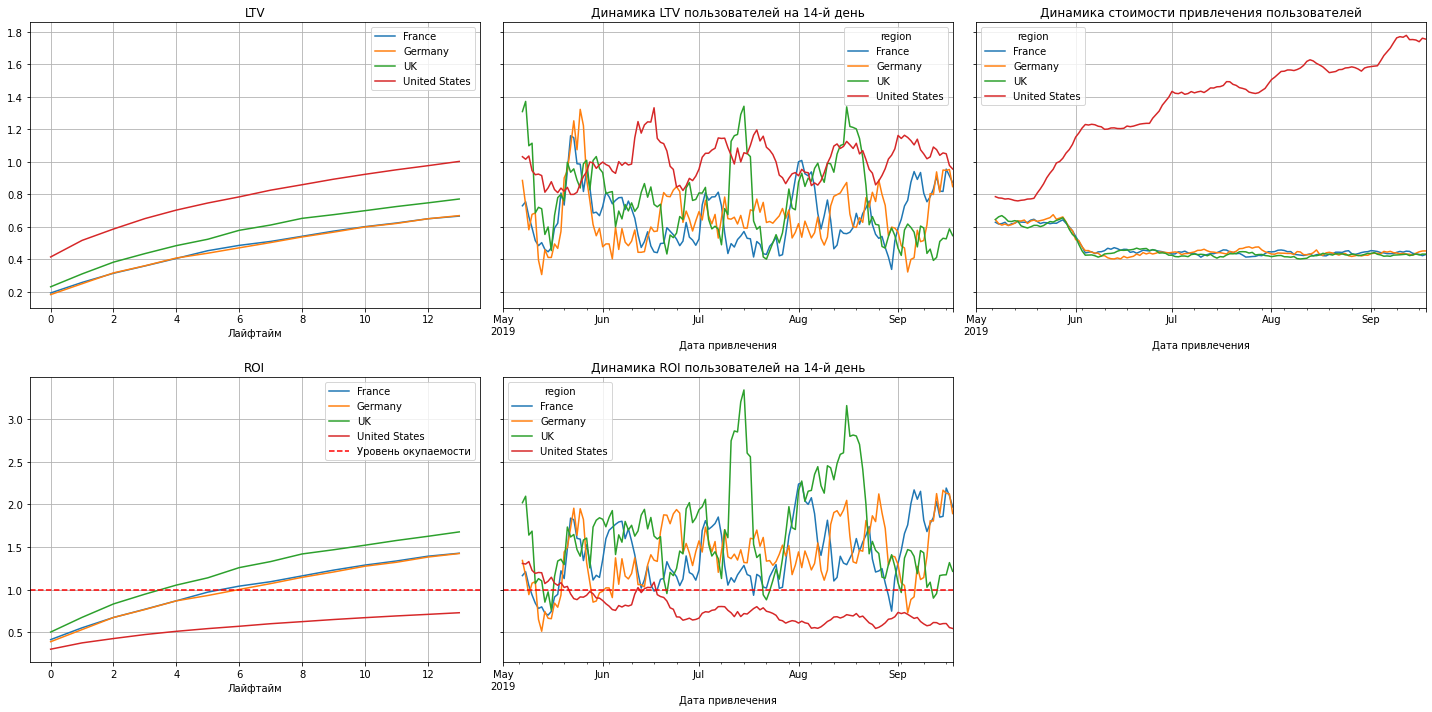

In [70]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [71]:
conversion_raw, conversion, conversion_history = get_conversion(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)
retention_raw, retention, retention_history = get_retention(ad_profiles, visits, observation_date, horizon_days, dimensions=dimensions)

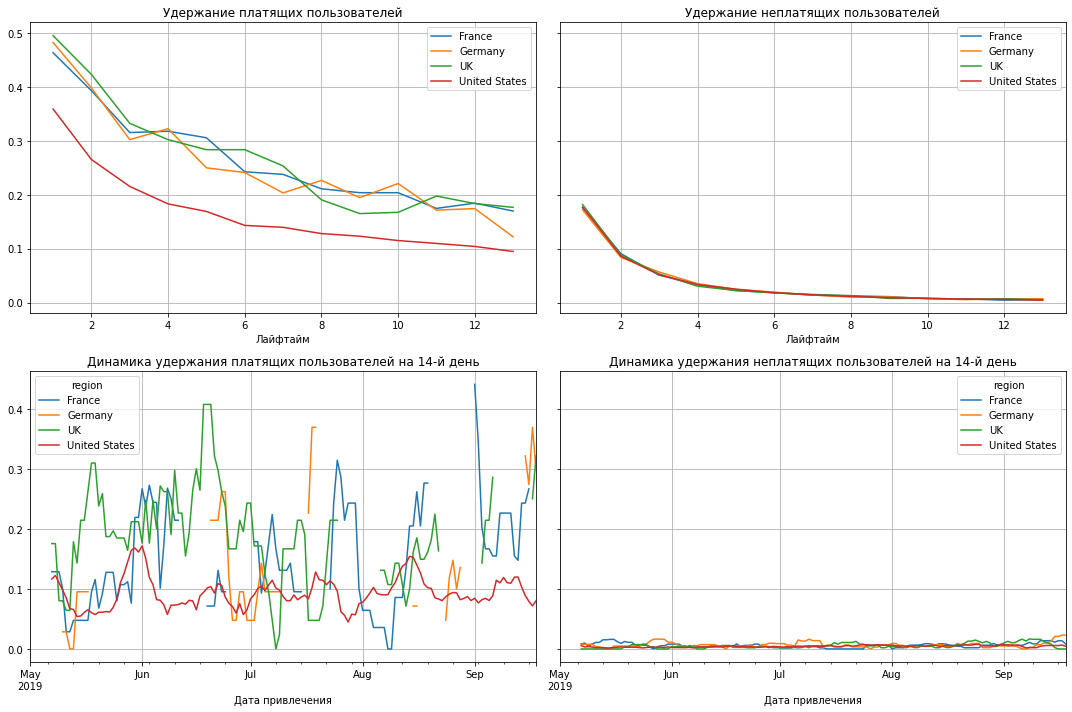

In [72]:
plot_retention(retention, retention_history, horizon_days)

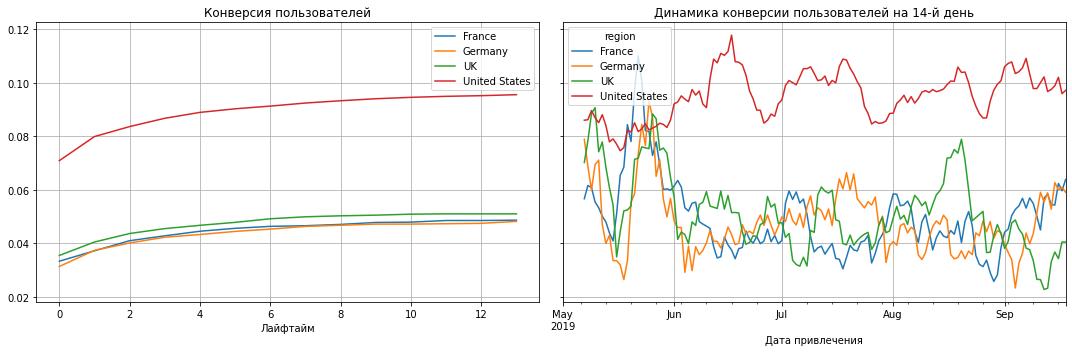

In [73]:
plot_conversion(conversion, conversion_history, horizon_days)

Среди регионов, ROI менее единицы показывает только одна страна: США. При наибольшем коэффициенте LTV, она имеет крайне большую стоимость привлечения клиента, что, в конечном итоге, отрицательно сказывается на окупаемости. Из разбивки всех пользователей приложения по странам, было выяснено, что клиенты из США достигают 67% всех пользователей. Неокупаемость этих клиентов критически сильно влияет на общие показатели. Заметим также, что США показывает наихудший результат по удержанию платящих пользователей. При всем при этом, пользователи из Штатов переходят из посетителей в платящих клиентов гораздо лучше, чем в любой из других 3-х стран: в 2 раза.

### Показатели в разбивке по источникам трафика

In [74]:
dimensions = ['channel']

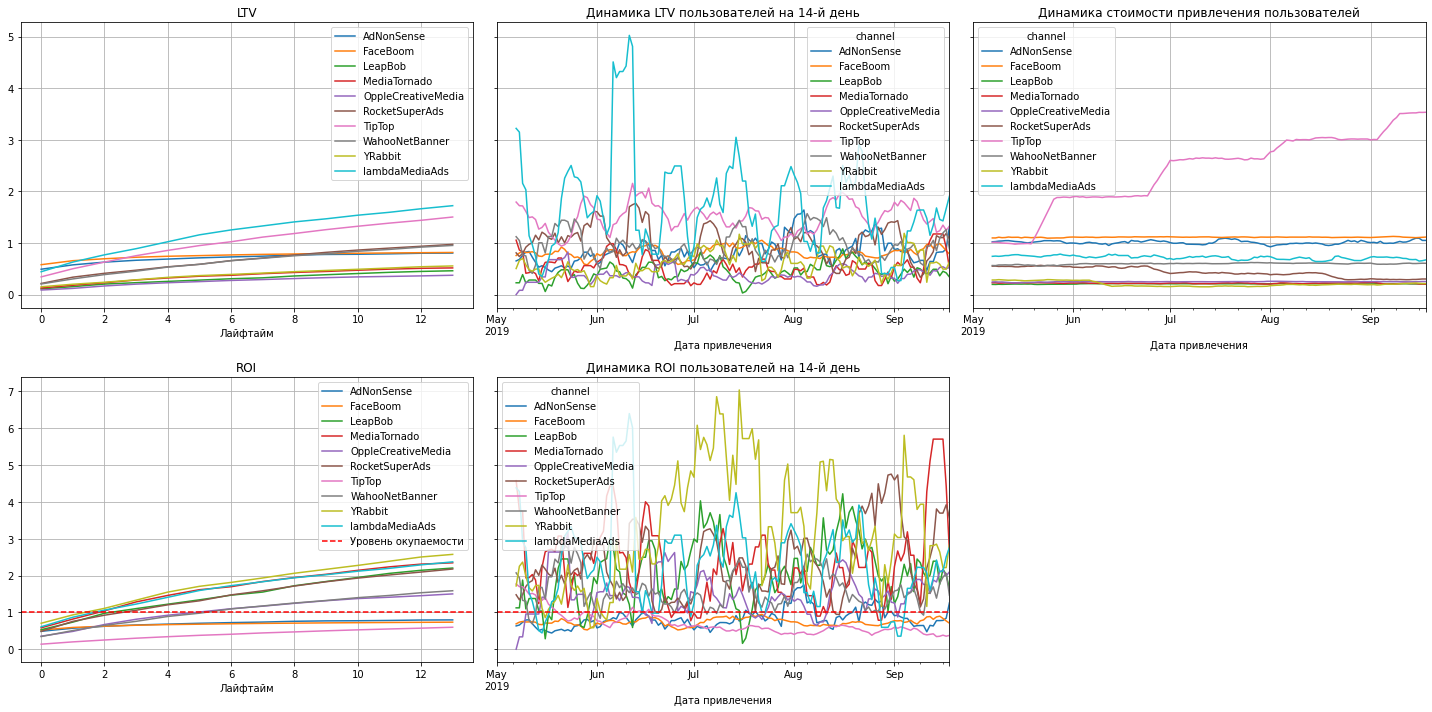

In [75]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [76]:
conversion_raw, conversion, conversion_history = get_conversion(ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions)
retention_raw, retention, retention_history = get_retention(ad_profiles, visits, observation_date, horizon_days, dimensions=dimensions)

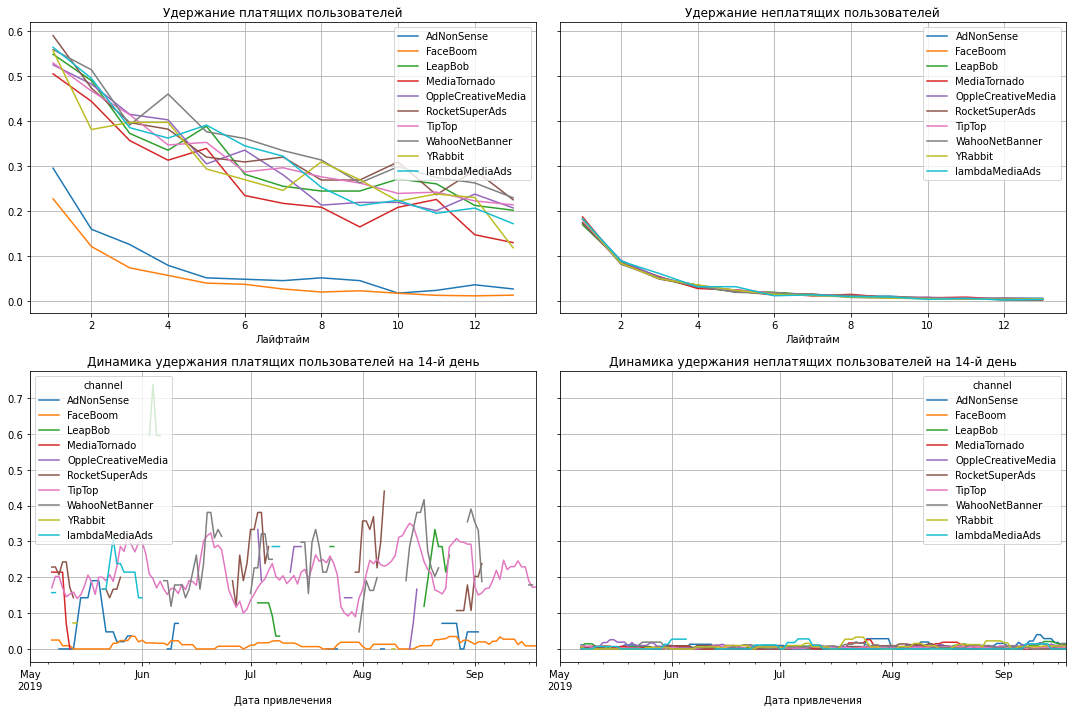

In [77]:
plot_retention(retention, retention_history, horizon_days)

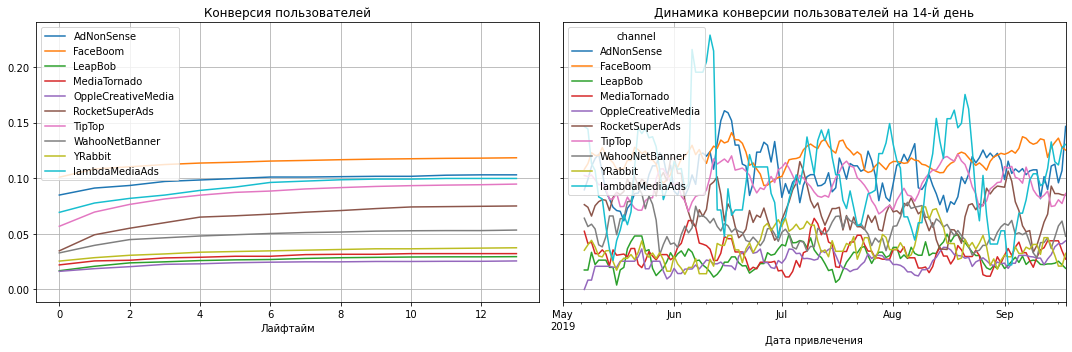

In [78]:
plot_conversion(conversion, conversion_history, horizon_days)

Среди источников трафика, есть три площадки, ROI которых не превышает 1, это TipTop, FaceBoom и AdNonSense. Лучше всех, здесь себя показывает YRabbit. Особенное внимание стоит обратить на динамику CAC для TipTop. Стоимость привлеченного пользователя постоянно растет при, относительно стабильном LTV. Причем растет коэффициент CAC рывками. На графике видно 4 резких увеличений в цене клиента TipTop. В графиках для всех рекламных источников проблематично оценивать результаты из-за большого количества кривых, поэтому все те же графики были построены для топ-4 площадок по объему привлеченной аудитории, а также была включена YRabbit, благодаря своим хорошим показателям окупаемости.

### Показатели в разбивке по источникам трафика (TipTop, FaceBoom, AdNonSense, lambdaMediaAds, YRabbit)

In [79]:
channel_profiles = ad_profiles.loc[ad_profiles['channel'].isin(['TipTop', 'FaceBoom', 
                                                             'AdNonSense', 'lambdaMediaAds', 
                                                             'YRabbit'])]
dimensions = ['channel']

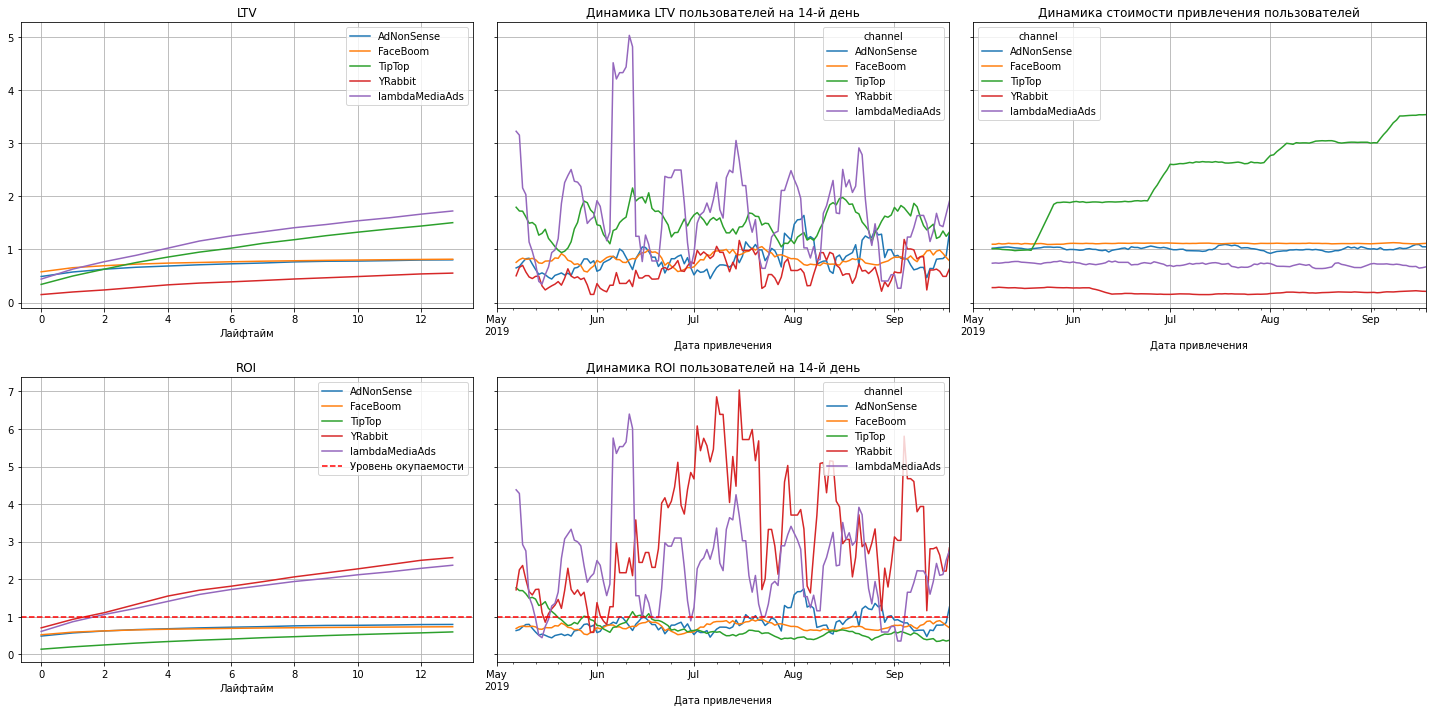

In [80]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(channel_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [81]:
conversion_raw, conversion, conversion_history = get_conversion(channel_profiles, orders, observation_date, horizon_days, dimensions=dimensions)
retention_raw, retention, retention_history = get_retention(channel_profiles, visits, observation_date, horizon_days, dimensions=dimensions)

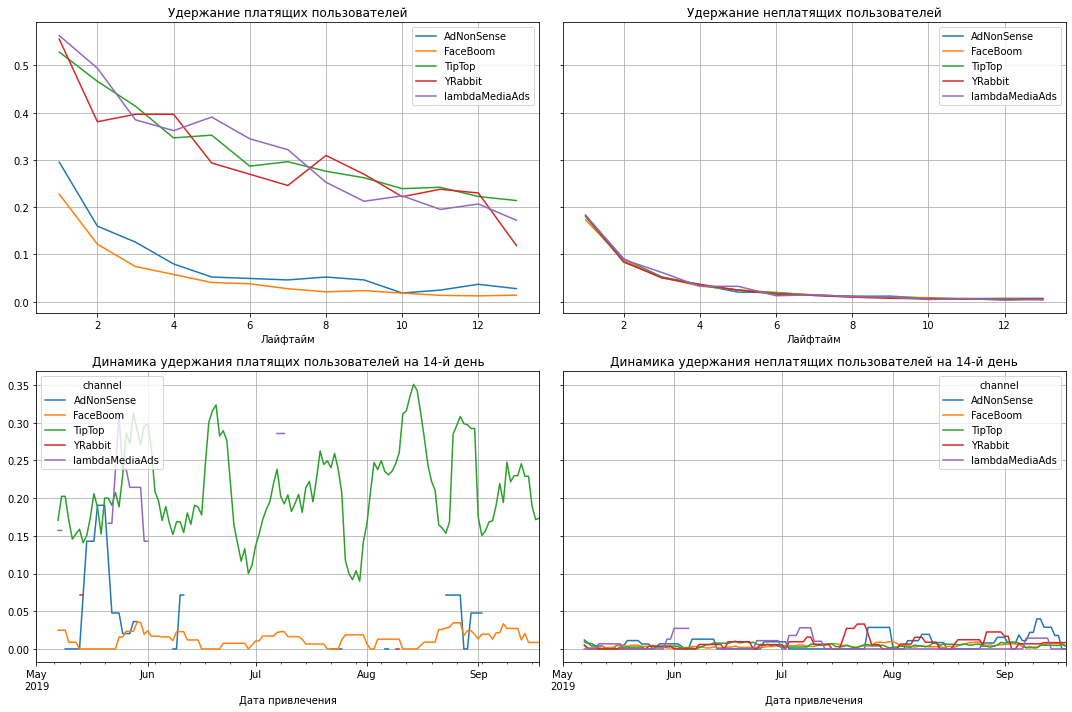

In [82]:
plot_retention(retention, retention_history, horizon_days)

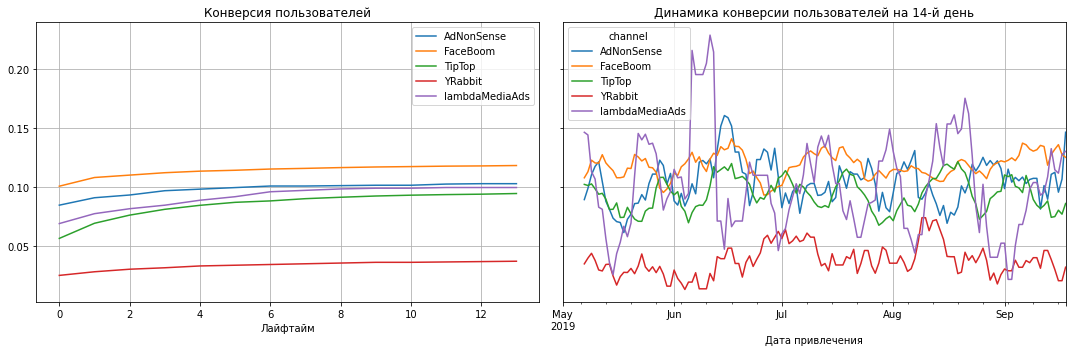

In [83]:
plot_conversion(conversion, conversion_history, horizon_days)

Рекламные источники (5 избранных каналов): Заметим, что при сильно завышенной и растущей стоимости клиента из TipTop, общий показатель LTV для этой площадки все равно ниже, чем у lambdaMediaAds. На графике удержания пользователей, как для всех площадок, так и для 5-ти выбранных, есть две отстающие: FaceBoom и AdNonSense. Топ-4 площадок по объему привлеченной аудитории показывают наилучший результат по конверсии пользователей.

### Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Среди устройств нет сильно выбивающихся показателей. Предположительно, проблемная рекламная платформа может негативно повлиять на определенные устройства, тем самым, занизив их показатели. Среди стран, явно выбивается США. Она занимает бОльшую часть всей аудитории приложения и имеет отрицательный коэффициент ROI. Однако и здесь возможен вариант негативного влияния рекламного канала. На эти мысли наводит график динамики CAC США и TipTop. Замеченные ранее 4 рывка в стоимости пользователя TipTop видны и на динамике коэффициента CAC у Штатов. Для более точного вывода требуется рассмотреть TipTop подробнее. Помимо этого, интересно посмотреть на FaceBoom, так как эта площадка привлекла наибольшее количество пользователей.

### Анализ окупаемости рекламного трафика TipTop и FaceBoom

In [84]:
tiptop_profiles = ad_profiles.loc[ad_profiles['channel'] == 'TipTop']
faceboom_profiles = ad_profiles.loc[ad_profiles['channel'] == 'FaceBoom']

In [85]:
(
    tiptop_profiles
    .groupby('region')
    .agg({'user_id':'count', 'payer':'mean'})
    .sort_values(by='user_id', ascending=False)
    .style.format({'payer':'{:.2%}'})
)

In [86]:
(
    faceboom_profiles
    .groupby('region')
    .agg({'user_id':'count', 'payer':'mean'})
    .sort_values(by='user_id', ascending=False)
    .style.format({'payer':'{:.2%}'})
)

Заметим, что все пользователи, пришедшие из TipTop и FaceBoom находятся в США. Это подтверждает предположение о том, что на показатели Штатов влияют именно рекламные площадки.

In [87]:
dimensions = ['device']

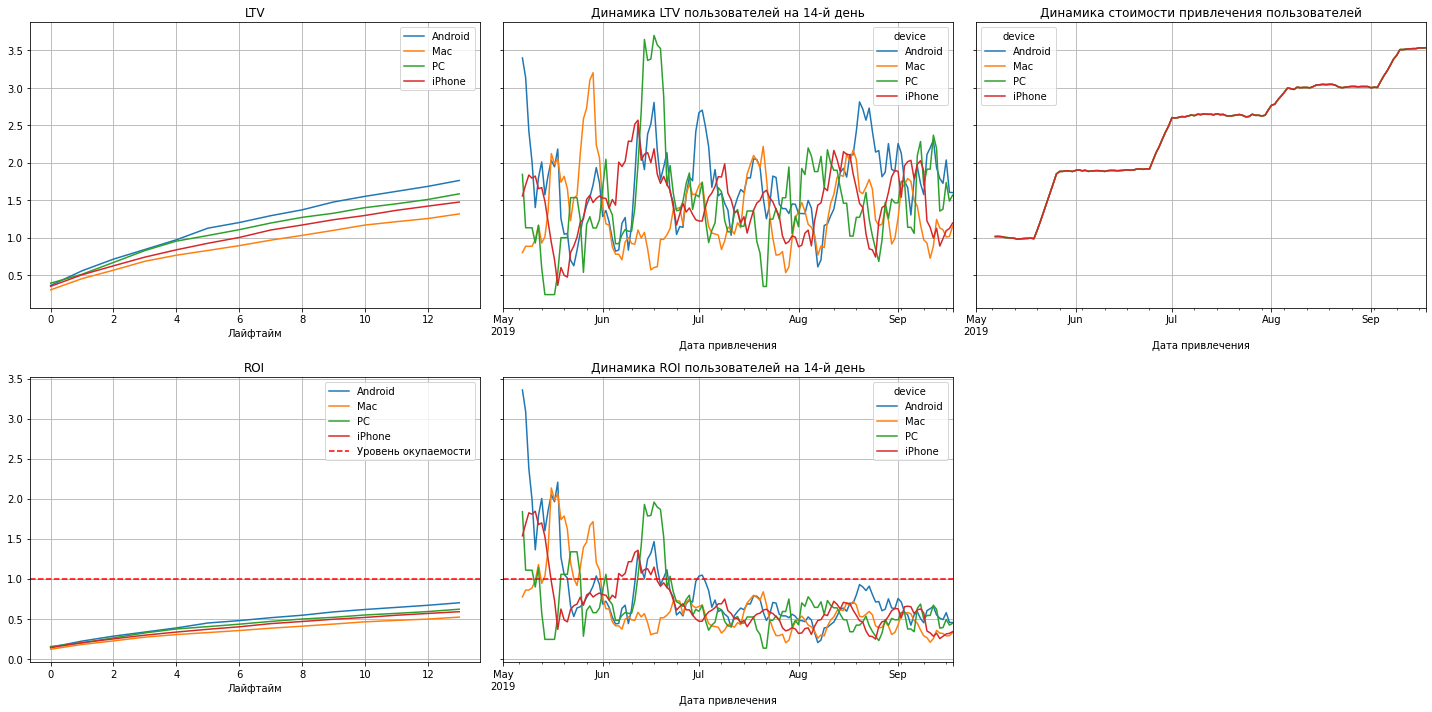

In [88]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(tiptop_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

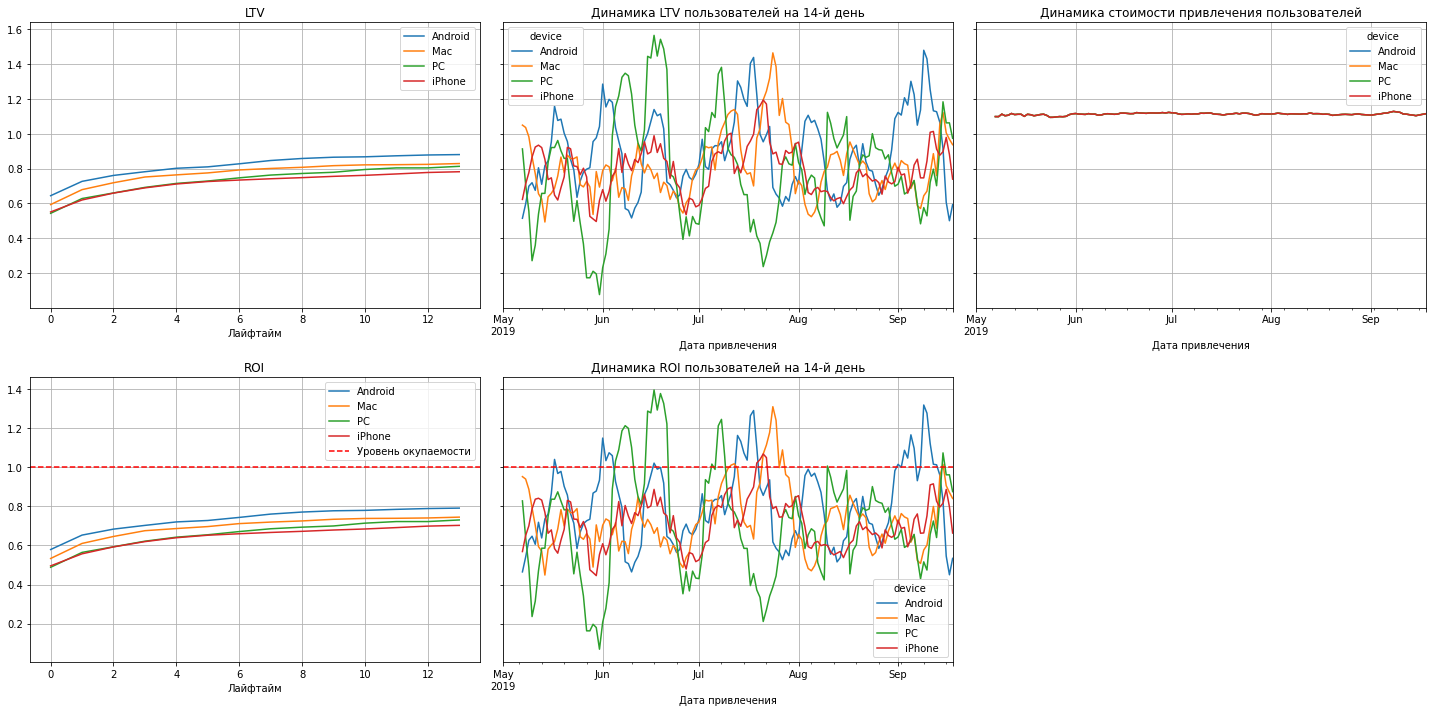

In [89]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(faceboom_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Для каждой из двух самых больших площадок, какой-либо особенности в различных девайсах не обнаружено.

### Чем могут быть вызваны проблемы окупаемости?

Проблемы могут быть вызваны неверным распределением рекламных средств. Огромная часть потраченного рекламного капитала ушла в две площадки TipTop и FaceBoom. Обе эти площадки показали отрицательную окупаемость.

Рассмотрим теперь профили с "хорошими" каналами трафика, то есть с теми, у которых коэффициент ROI > 1.

In [90]:
good_channel_profiles = ad_profiles.loc[~ad_profiles['channel'].isin(['TipTop', 'FaceBoom', 'AdNonSense'])]
good_channel_profiles.channel.unique()

array(['YRabbit', 'MediaTornado', 'RocketSuperAds', 'LeapBob',
       'WahooNetBanner', 'OppleCreativeMedia', 'lambdaMediaAds'],
      dtype=object)

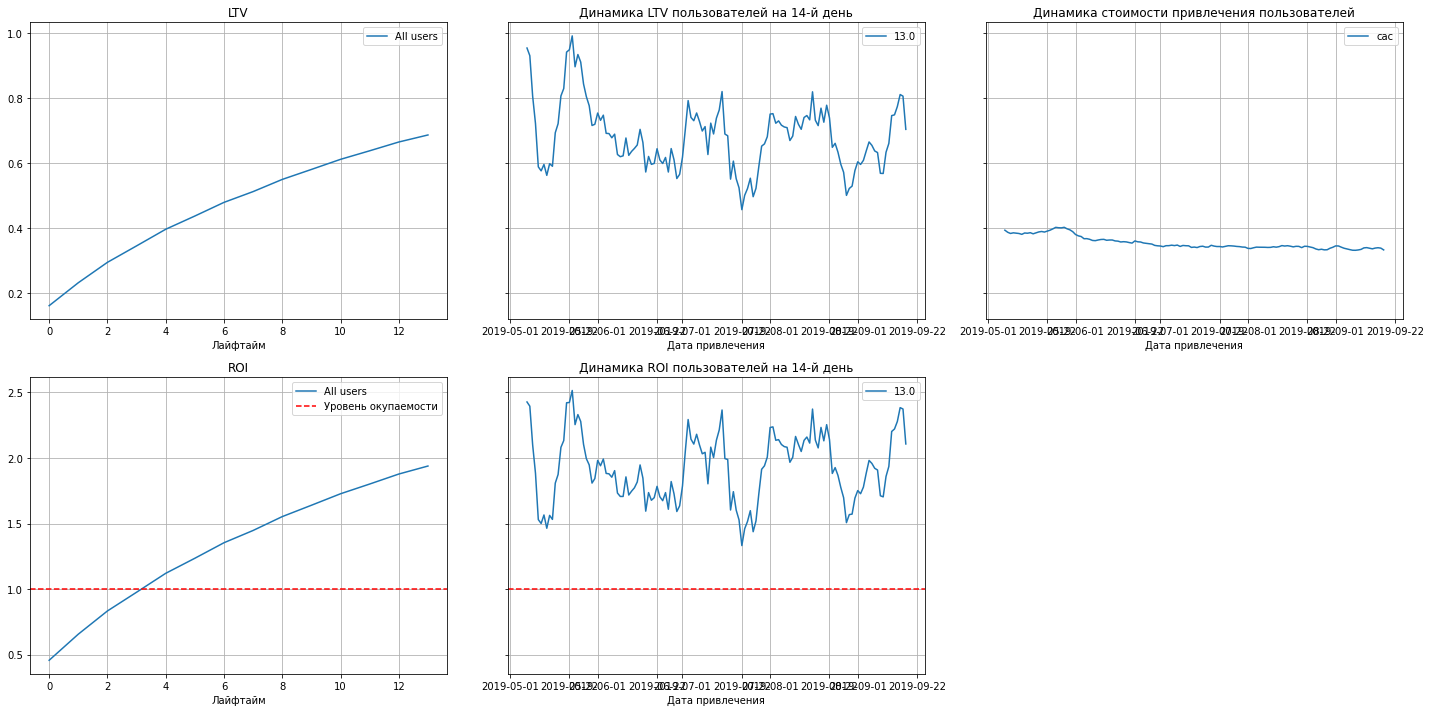

In [91]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(good_channel_profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

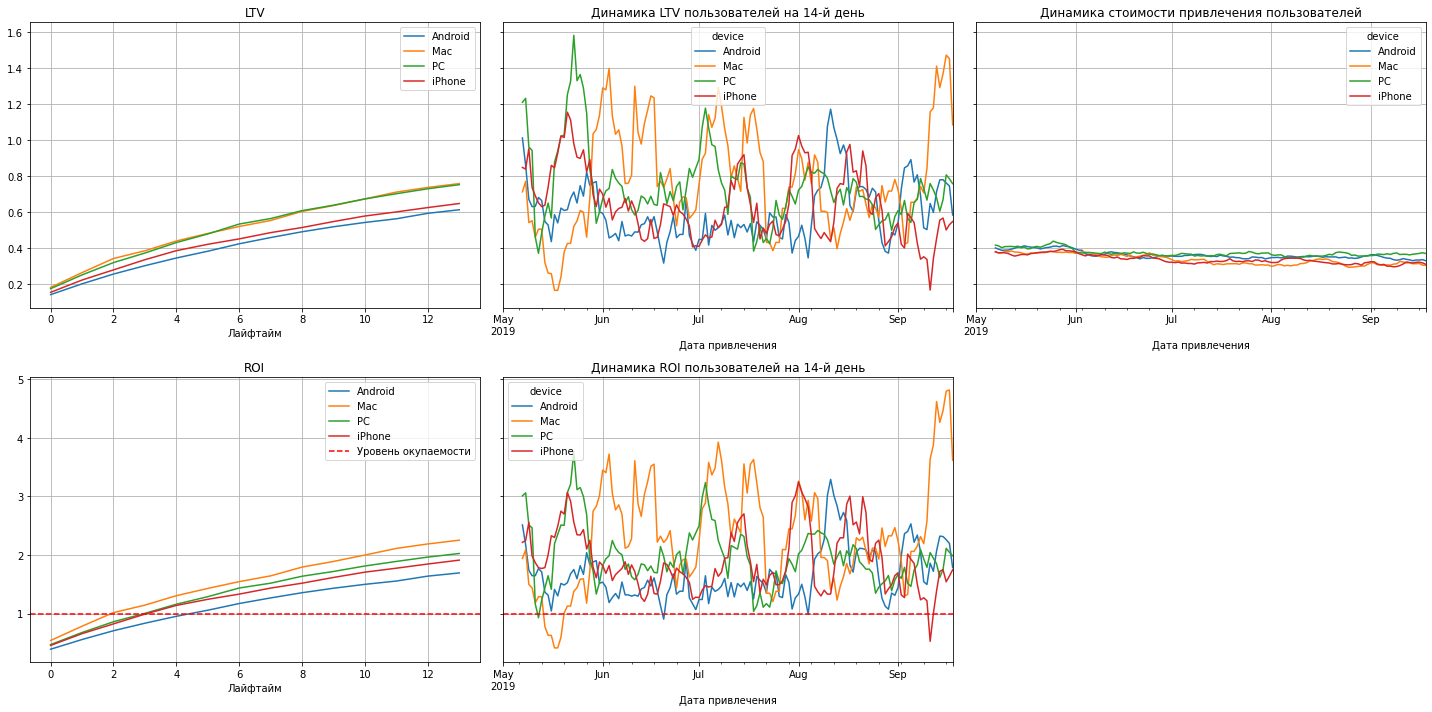

In [92]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(good_channel_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

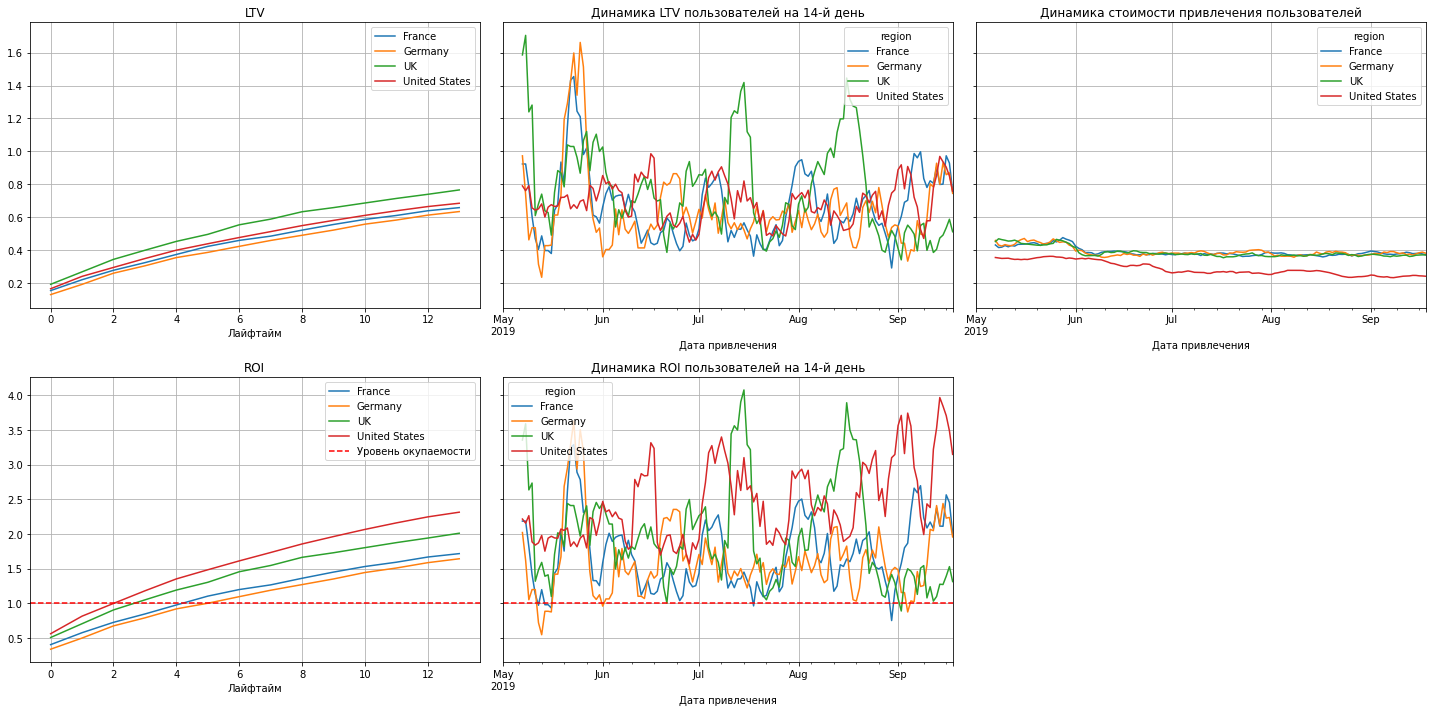

In [93]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(good_channel_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из данных графиков видно, что после того, как мы убрали из анализа каналы с отрицательным ROI, все показатели заметно улучшились, причем как общие, так и разбивочные. На новых графиках исчезли проблемы с плохими показателями IPhone и Mac, а также с особенно негативными результатами США. США теперь, наоборот, показывает наилучший коэффициент ROI с минимальным CAC. 

**Рекомендации для рекламного отдела:** Помимо остановки всех рекламных интеграций на TipTop, FaceBoom и AdNonSense, возможен вариант смены контента для привлечения аудитории, особенно, если он сильно отличался от контента на других, более "удачных" площадках. Естественно, вложения в рекламу на этих площадках должны стать сильно ниже и не занимать больше 5% рекламного бюджета. Показатели TipTop довольно неплохие относительно остальных, если не считать стоимость привлечения клиента. Возможен вариант более агрессивной "кликбейтной" рекламы на этом канале или фиксированная оплата за привлеченного пользователя. Что касается FaceBoom и AdNonSense, основная проблема этих площадок заключается в удержании клиента, поэтому в этом случае можно предложить наоборот, более спокойную или правдивую рекламу, чтобы привлеченные пользователи оставались как можно дольше.

## Шаг. Выводы

В данном проекте была произведена предобработка данных, исследовательский анализ данных, анализ маркетинговых показателей, а также оценка окупаемости рекламы. Было рассмотрено 3 датасета: с информацией о посещениях сайта, заказах и расходах на рекламу. При анализе было замечено следующее:

1. Во всех трех таблицах названия столбцов были написаны некорректно и были переделаны. Пропусков и дубликатов найдено не было. Типы данных в столбцах, содержащих информацию о времени, были переделаны в корректные.
2. Реклама вышла на каждой площадке ровно по 180 раз.В кампании участвовало 10 рекламных платформ. С 01.05.2019 по 27.10.2019 реклама выходила каждый день по 10 интеграций в день, приложением, за этот промежуток времени, воспользовалось 150008 различных пользователей.
3. Приложением пользуются клиенты и 4-х стран: США, Великобритания, Франция и Германия. Абсолютное большинство пользователей приходит из США (67% от общего количества привлеченных пользователей). 
4. Пользователи заходят в Procrastinate Pro+ с 4-х различных устройств: Мак, Айфон, Андройд и ПК.
5. Больше всего аудитории привлекли из двух рекламных площадок:  TipTop и FaceBoom.
6. Всего было потрачено 105497 у.е. на рекламу, из которых 83% было вложено в рекламу на TipTop и FaceBoom.
7. За весь промежуток рекламных кампаний, пользователь из TipTop оказался самым дорогим, причем с огромным отрывом от остальных площадок: он в 2.5 раза дороже, чем клиент из второй по стоимости привлеченного пользователя компании - FaceBoom и более, чем в 13 раз дороже клиента из LeapBob - площадки с самым дешевым пользователем.
8. Реклама, направленная на привлечение пользователей в целом, не окупается. Об этом говорит коэффициент ROI, немного бОльший значения 0.8. Причем чем дольше шла рекламная кампания, тем хуже оказывались результаты.
9. Проблема кампании оказалась заключена в трех каналах привлечения аудитории: TipTop, FaceBoom и AdNonSense. Все три площадки не окупают вложения, а при том, что только в первые две из них было вложено 83% всего рекламного бюджета, результат не удивителен.

**Рекомендации для отдела маркетинга:** Большие траты на рекламу в TipTop, FaceBoom и AdNonSense, привели к тому, что рекламная кампания провалилась. Пока стоимость рекламы на площадке TipTop не упадет примерно в 3 раза, рекламу покупать там не рекомендуется. Источники FaceBoom и AdNonSense имеют крайне низкие показатели удержания клиентов. Необходимо либо останавливать рекламу на этих трех площадках и фокусироваться на рекламе в YRabbit, lambdaMediaAds, OppleCreativeMedia, LeapBob и RocketSuperAds (эти площадки показали наилучшую окупаемость), либо пересмотреть рекламный контент на TipTop, FaceBoom и AdNonSense. Первый вариант предпочтительней. Для реализации второго варианта обязательно необходимо сильно уменьшить рекламный бюджет для этих трех каналов трафика (не более 5%, в идеале около 2%). Продолжительные вложения в канал YRabbit также не рекомендуются. Наилучшую окупаемость аудитория с этой площадки показывает лишь за счет своей низкой стоимости привлечения. Конверсия и удержание на последних днях в YRabbit малы, по сравнению со всеми остальными "удачными" площадками. Если САС в будущем будет возрастать, коэфициент ROI может очень быстро перейти в отрицательный. 